In [3]:
# EXAMPLE : Linear Regression with Spark MLlib
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Initialize Spark Session
spark = SparkSession.builder.appName('MLlib Example').getOrCreate()

# Load sample data
data = [(1, 5.0, 20.0), (2, 10.0, 25.0), (3, 15.0, 30.0), (4, 20.0, 35.0)]
columns = ['ID', 'Feature', 'Target']
df = spark.createDataFrame(data, columns)

# Prepare data for modeling
assembler = VectorAssembler(inputCols=['Feature'], outputCol='Features')
df_transformed = assembler.transform(df)

# Train a linear regression model
lr = LinearRegression(featuresCol='Features', labelCol='Target')
model = lr.fit(df_transformed)

# Print model coefficients
print(f'Coefficients: {model.coefficients}')
print(f'Intercept: {model.intercept}')

25/12/03 19:38:08 WARN Instrumentation: [20d9f951] regParam is zero, which might cause numerical instability and overfitting.
                                                                                

Coefficients: [0.9999999999999992]
Intercept: 15.000000000000009


In [6]:
# PRACTICE 1 : Logistic Regression
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

# Initialize spark session
spark = SparkSession.builder.appName("Practice1_LogReg").getOrCreate()

# Dataset contoh
data = [
    (1, 2.0, 3.0, 0),
    (2, 1.0, 5.0, 1),
    (3, 2.5, 4.5, 1),
    (4, 3.0, 6.0, 0)]

columns = ["ID", "f1", "f2", "Label"]
df = spark.createDataFrame(data, columns)

# Gabungkan fitur ke format vector
assembler = VectorAssembler(
    inputCols=["f1", "f2"],
    outputCol="Features"
)
df2 = assembler.transform(df)

# Melatih model regresi logistik (Logistic Regression)
lr = LogisticRegression(featuresCol="Features", labelCol="Label")
model = lr.fit(df2)

# Menampilkan koefisien dan ringkasan
print("Coefficients:", model.coefficients)
print("Intercept:", model.intercept)

25/12/03 19:59:29 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
                                                                                

Coefficients: [-12.26205794868134,4.087352272988278]
Intercept: 11.56891274614735


In [7]:
# PRACTICE 2 : KMeans Clustering
from pyspark.ml.clustering import KMeans
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

spark = SparkSession.builder.appName("Practice2_KMeans_Fix").getOrCreate()

# Example dataset tanpa array/list python
data = [
    (1, 1.0, 1.0),
    (2, 5.0, 5.0),
    (3, 10.0, 10.0),
    (4, 15.0, 15.0)]

columns = ["ID", "x", "y"]
df = spark.createDataFrame(data, columns)

# Convert features ke vector 
assembler = VectorAssembler(
    inputCols=["x", "y"],
    outputCol="Features"
)
df2 = assembler.transform(df)

# Train KMeans clustering model
kmeans = KMeans(featuresCol="Features", k=2)
model = kmeans.fit(df2)

# Output cluster centers
print("Cluster Centers:")
for c in model.clusterCenters():
    print(c)

25/12/03 20:27:39 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
                                                                                

Cluster Centers:
[12.5 12.5]
[3. 3.]


In [20]:
# HOMEWORK
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer

# Initialize Spark
spark = SparkSession.builder.appName("HomeworkClassification").getOrCreate()

# Load real-world dataset 
data_path = "/home/zara/Downloads/archive/Titanic-Dataset.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Lihat 5 data awal
df.limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [11]:
# CEK MISSING VALUES
from pyspark.sql.functions import col, count, when

missing = (df
    .select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
    .toPandas() # Konversi ke Pandas untuk hasilnya
    .T # Transpose (format ke bawah)
    .reset_index()
)

missing.columns = ["column", "missing_count"]
print(missing)

         column  missing_count
0   PassengerId              0
1      Survived              0
2        Pclass              0
3          Name              0
4           Sex              0
5           Age            177
6         SibSp              0
7         Parch              0
8        Ticket              0
9          Fare              0
10        Cabin            687
11     Embarked              2


In [15]:
# HANDLE MISSING VALUES

from pyspark.sql.functions import mean, col, when, count

# 1. DROP kolom Cabin (karena terlalu banyak missing)
df = df.drop("Cabin")

# 2. Hitung nilai mean Age untuk mengisi missing
mean_age = df.select(mean("Age")).first()[0]

# 3. Isi missing values untuk Age dan Embarked
df_clean = df.fillna({
    "Age": mean_age,
    "Embarked": "S"  # Nilai paling umum
})

# CEK MISSING VALUES AFTER HANDLING
missing_after = (df_clean
    .select([count(when(col(c).isNull(), c)).alias(c) for c in df_clean.columns])
    .toPandas()
    .T
    .reset_index()
)

missing_after.columns = ["column", "missing_count"]
print(missing_after)


         column  missing_count
0   PassengerId              0
1      Survived              0
2        Pclass              0
3          Name              0
4           Sex              0
5           Age              0
6         SibSp              0
7         Parch              0
8        Ticket              0
9          Fare              0
10     Embarked              0


In [16]:
# Convert kolom kategori ke numerik (StringIndexer)
from pyspark.ml.feature import StringIndexer

# Sex
sex_indexer = StringIndexer(inputCol="Sex", outputCol="SexIndexed")
df = sex_indexer.fit(df).transform(df)

# Embarked
embarked_indexer = StringIndexer(inputCol="Embarked", outputCol="EmbarkedIndexed")
df = embarked_indexer.fit(df).transform(df)

In [19]:
# Buat kolom features (VectorAssembler)
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["Pclass","SexIndexed","Age","SibSp","Parch","Fare","EmbarkedIndexed"],
    outputCol="features"
)

df_final = assembler.transform(df)
df_final.select("features", "Survived").limit(5).toPandas()

,features,Survived
0,"[3.0, 0.0, 22.0, 1.0, 0.0, 7.25, 0.0]",0
1,"[1.0, 1.0, 38.0, 1.0, 0.0, 71.2833, 1.0]",1
2,"[3.0, 1.0, 26.0, 0.0, 0.0, 7.925, 0.0]",1
3,"[1.0, 1.0, 35.0, 1.0, 0.0, 53.1, 0.0]",1
4,"(3.0, 0.0, 35.0, 0.0, 0.0, 8.05, 0.0)",0


In [21]:
# Split data (Train-Test)
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

In [23]:
# Train Classification Model (Logistic Regression)
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="features",
    labelCol="Survived"
)

lr_model = lr.fit(train_data)

In [24]:
 # Evaluasi model (akurasi)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = lr_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(
    labelCol="Survived",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8137931034482758


In [25]:
# Hyperparameter tuning using cross-validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

# Cross validation
cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

# Train with CV
cv_model = cv.fit(train_data)

# Evaluasi model CV
cv_predictions = cv_model.transform(test_data)
cv_accuracy = evaluator.evaluate(cv_predictions)
print("CV Accuracy:", cv_accuracy)

CV Accuracy: 0.8068965517241379


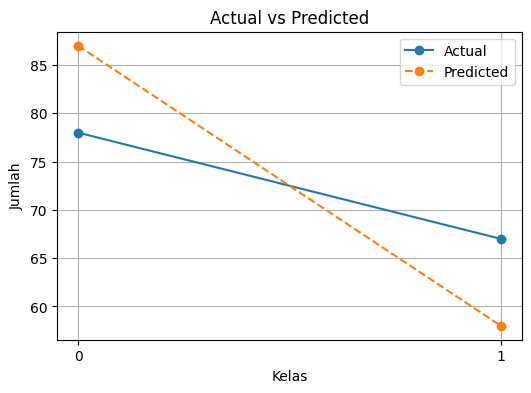

In [30]:
# VISUALISASI
# Convert spark result ke pandas
pred_pdf = predictions.select("Survived", "prediction").toPandas()

import matplotlib.pyplot as plt

# Hitung frekuensi
actual = pred_pdf["Survived"].value_counts().sort_index()
pred   = pred_pdf["prediction"].value_counts().sort_index()

actual_vals = [actual.get(0, 0), actual.get(1, 0)]
pred_vals   = [pred.get(0, 0), pred.get(1, 0)]
labels = ["0", "1"]

plt.figure(figsize=(6,4))

plt.plot(labels, actual_vals, marker='o', label="Actual")
plt.plot(labels, pred_vals, marker='o', linestyle='--', label="Predicted")

plt.title("Actual vs Predicted")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.legend()
plt.grid(True)
plt.show()